In [19]:
# Program To Read video 
# and Extract Frames 

# import sys
# !{sys.executable} -m pip install opencv-python
# !{sys.executable} -m pip install moviepy

import torch 
import numpy as np
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F


In [79]:
BATCH_SIZE = 5
num_groups = 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
train_dataset = torchvision.datasets.STL10('datasets/stl10', split='train', download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()]))

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting datasets/stl10\stl10_binary.tar.gz to datasets/stl10


In [71]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle = True)


Label (numeric): 1
Label (textual): bird


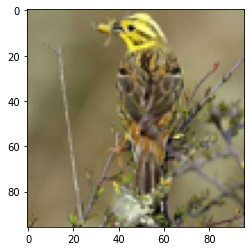

In [12]:
img, label = train_dataset[0]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', train_dataset.classes[label])

In [29]:
count_class = {}
for _,outs in train_dataset: 
    labels = train_dataset.classes[outs]
    if labels not in count_class:
        count_class[labels] = 0
    count_class[labels] += 1 
count_class 

{'bird': 500,
 'dog': 500,
 'horse': 500,
 'cat': 500,
 'truck': 500,
 'monkey': 500,
 'deer': 500,
 'ship': 500,
 'airplane': 500,
 'car': 500}

In [81]:
from torch.nn.parameter import Parameter
from torch.autograd import Function


class Conv2d(nn.Conv2d):

    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        super(Conv2d, self).__init__(in_channels, out_channels, kernel_size, stride,
                 padding, dilation, groups, bias)

    def forward(self, x):
        weight = self.weight
        weight_mean = weight.mean(dim=1, keepdim=True).mean(dim=2,
                                  keepdim=True).mean(dim=3, keepdim=True)
        weight = weight - weight_mean
        std = torch.pow(weight.view(weight.size(0), -1).var(dim=1) + 1e-5, 0.5).view(-1, 1, 1, 1)
        weight = weight / std.expand_as(weight)
        return F.conv2d(x, weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)



class BCNorm(nn.Module):
#     eps = epsilon
    def __init__(self, num_channels, num_groups, eps, estimate=False):
        super(BCNorm, self).__init__()
        self.num_channels = num_channels
        self.num_groups = num_groups
        self.eps = eps
        self.weight = Parameter(torch.ones(1, num_groups, 1))
        self.bias = Parameter(torch.zeros(1, num_groups, 1))
        if estimate:
            self.bn = EstBN(num_channels)
        else:
            self.bn = nn.BatchNorm2d(num_channels)

    def forward(self, inp):
        out = self.bn(inp)
        out = out.view(1, inp.size(0) * self.num_groups, -1)
        out = torch.batch_norm(out, None, None, None, None, True, 0, self.eps, True)
        out = out.view(inp.size(0), self.num_groups, -1)
        out = self.weight * out + self.bias
        out = out.view_as(inp)
        return out
    
class EstBN(nn.Module):

    def __init__(self, num_features):
        super(EstBN, self).__init__()
        self.num_features = num_features
        self.weight = Parameter(torch.ones(num_features))
        self.bias = Parameter(torch.zeros(num_features))
        self.register_buffer('running_mean', torch.zeros(num_features))
        self.register_buffer('running_var', torch.ones(num_features))
        self.register_buffer('num_batches_tracked', torch.tensor(0, dtype=torch.long))
        self.register_buffer('estbn_moving_speed', torch.zeros(1))

    def forward(self, inp):
        ms = self.estbn_moving_speed.item()
        if self.training:
            with torch.no_grad():
                inp_t = inp.transpose(0, 1).contiguous().view(self.num_features, -1)
                running_mean = inp_t.mean(dim=1)
                inp_t = inp_t - self.running_mean.view(-1, 1)
                running_var = torch.mean(inp_t * inp_t, dim=1)
                self.running_mean.data.mul_(1 - ms).add_(ms * running_mean.data)
                self.running_var.data.mul_(1 - ms).add_(ms * running_var.data)
        out = inp - self.running_mean.view(1, -1, 1, 1)
        out = out / torch.sqrt(self.running_var + 1e-5).view(1, -1, 1, 1)
        weight = self.weight.view(1, -1, 1, 1)
        bias = self.bias.view(1, -1, 1, 1)
        out = weight * out + bias
        return out

In [82]:
eps=1e-08
input_size = 3
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        vgg16 = [input_size, input_size, 'M', 64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
        self.features = self._make_layers(vgg16)
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = input_size
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [Conv2d(in_channels, x, kernel_size=3, padding=1),
                           BCNorm(x, num_groups, eps),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [52]:
# For weight standardization
# Only replace convolutions followed by normalizatin !!

# class Conv2d(nn.Conv2d):

#     def __init__(self, in_channels, out_channels, kernel_size, stride=1,
#                  padding=0, dilation=1, groups=1, bias=True):
#         super(Conv2d, self).__init__(in_channels, out_channels, kernel_size, stride,
#                  padding, dilation, groups, bias)

#     def forward(self, x):
#         weight = self.weight
#         weight_mean = weight.mean(dim=1, keepdim=True).mean(dim=2,
#                                   keepdim=True).mean(dim=3, keepdim=True)
#         weight = weight - weight_mean
#         std = weight.view(weight.size(0), -1).std(dim=1).view(-1, 1, 1, 1) + 1e-5
#         weight = weight / std.expand_as(weight)
#         return F.conv2d(x, weight, self.bias, self.stride,
#                         self.padding, self.dilation, self.groups)

In [ ]:
torch.manual_seed(43)
val_size = 1500
test_size = len(test_dataset) - val_size

In [32]:
test_dataset = torchvision.datasets.STL10('datasets/test_stl10', split='test', download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()]))

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting datasets/test_stl10\stl10_binary.tar.gz to datasets/test_stl10


In [37]:
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle = True)

In [33]:
count_class = {}
for _,outs in test_dataset: 
    labels = test_dataset.classes[outs]
    if labels not in count_class:
        count_class[labels] = 0
    count_class[labels] += 1 
count_class 

{'horse': 800,
 'monkey': 800,
 'dog': 800,
 'airplane': 800,
 'cat': 800,
 'bird': 800,
 'deer': 800,
 'truck': 800,
 'car': 800,
 'ship': 800}

In [ ]:
torch.manual_seed(43)
plt.title("Training loss vs Epoch")
plt.xlabel('Epoch')
plt.ylabel('Training loss')
model = VGG().to(device)
criterion = nn.CrossEntropyLoss() 
epochs = 10
params = model.parameters()
optimizer = torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs): # training our model, put input according to every batch.

    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0

    for inputs, labels in train_data_loader:
        inputs = inputs.to(device) # input to device as our model is running in mentioned device.
        labels = labels.to(device)
        outputs = model(inputs) # every batch of 100 images are put as an input.
        loss = criterion(outputs, labels) # Calc loss after each batch i/p by comparing it to actual labels. 

        optimizer.zero_grad() #setting the initial gradient to 0
        loss.backward() # backpropagating the loss
        optimizer.step() # updating the weights and bias values for every single step.

        _, preds = torch.max(outputs, 1) # taking the highest value of prediction.
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data) # calculating te accuracy by taking the sum of all the correct predictions in a batch.

    with torch.no_grad(): # we do not need gradient for validation.
        for val_inputs, val_labels in test_data_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)

            _, val_preds = torch.max(val_outputs, 1)
            val_running_loss += val_loss.item()
            val_running_corrects += torch.sum(val_preds == val_labels.data)

    epoch_loss = running_loss/len(train_data_loader) # loss per epoch
    epoch_acc = running_corrects.float()/ len(train_dataset) # accuracy per epoch
    running_loss_history.append(epoch_loss) # appending for displaying 
    running_corrects_history.append(epoch_acc.cpu())

    val_epoch_loss = val_running_loss/len(test_data_loader)
    val_epoch_acc = val_running_corrects.float()/ len(test_dataset)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc.cpu())
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))
    label = 'Micro batch'
    plt.plot(running_loss_history, label=label)

plt.legend()
plt.show()

epoch : 1
training loss: 1.9966, acc 0.2354 
validation loss: 1.7791, validation acc 0.3133 


In [87]:
len(train_dataset)

5000

1000

138240